In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz

In [3]:
################################################## HELPER FUNCTIONS #################################################################################### 
def z_scoring(x): 
    return (x - x.mean()) / x.std()

def range_normalization(x):
    return (x - x.mean()) / (x.max() - x.min())

def center_(x, cluster):
    return [np.mean(x[cluster, j]) for j in range(x.shape[1])]

# Used to group dataPoints in clusters
def distNorm(x ,remains, ranges, p):
    z = x[remains, :]
    az = np.tile(p, (len(remains), 1))
    rz = np.tile(ranges, (len(remains), 1))
    dz = (z - az) / rz
    return np.sum(dz * dz, axis=1)

# To See if it belongs to Cluster X?
def separCluster(x, remains, ranges, a, b):
    dista = distNorm(x, remains, ranges, a)
    distb = distNorm(x, remains, ranges, b)
    return [remains[i] for i in np.where(dista < distb)[0]]

def anomalousPattern(x, remains, ranges, centroid, me):
    while True:
        cluster = separCluster(x, remains, ranges, centroid, me)
        if not cluster:
            break
        newcenter = center_(x, cluster)
        if np.allclose(centroid, newcenter):
            break
        centroid = newcenter
    return cluster, centroid

def dist(x, remains, ranges, p):
    return np.sum(((x[remains] - p) / ranges) ** 2, axis=1)

# Optimized Vectorized implementation
# Validation / Criterion
def xie_beni_index(U, centers, X):
    um = U ** 2
    dist_sq = np.sum((X[np.newaxis, :, :] - centers[:, np.newaxis, :]) ** 2, axis=2)
    compactness = np.sum(um * dist_sq)

    center_dist_sq = np.sum((centers[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2, axis=2)
    np.fill_diagonal(center_dist_sq, np.inf)
    min_center_dist_sq = np.min(center_dist_sq)

    if min_center_dist_sq == 0:
        return np.inf
    return compactness / (X.shape[0] * min_center_dist_sq)

In [4]:
################################################## DATA PREPARATION #################################################################################### 

# a ) Normalize by range and z-score
# MERGED dataSet
df_r = pd.read_csv("./data/winequality-red.csv", sep=';')
df_w = pd.read_csv("./data/winequality-white.csv", sep=';')
data = pd.concat([df_r, df_w], ignore_index=True)

# Z-Score Normalization
data_ap_zscore = z_scoring(data)

# Range Normalization
data_ap_range = range_normalization(data)

# Convert to NumPy array for clustering
x = data_ap_range.values.astype(np.float32)

Seed: 1 | c=2 | Xie-Beni=1.7121
Seed: 42 | c=2 | Xie-Beni=1.7121
Seed: 70 | c=2 | Xie-Beni=1.7121
Seed: 100 | c=2 | Xie-Beni=1.7121
Seed: 200 | c=2 | Xie-Beni=1.7121
Seed: 1 | c=3 | Xie-Beni=1.7043
Seed: 42 | c=3 | Xie-Beni=1.6811
Seed: 70 | c=3 | Xie-Beni=1.6799
Seed: 100 | c=3 | Xie-Beni=1.6786
Seed: 200 | c=3 | Xie-Beni=1.6815
Seed: 1 | c=4 | Xie-Beni=2.1995
Seed: 42 | c=4 | Xie-Beni=11.3607
Seed: 70 | c=4 | Xie-Beni=2.8629
Seed: 100 | c=4 | Xie-Beni=5.7839
Seed: 200 | c=4 | Xie-Beni=44.4452
Seed: 1 | c=5 | Xie-Beni=8.5088
Seed: 42 | c=5 | Xie-Beni=77.2622
Seed: 70 | c=5 | Xie-Beni=6359.4653
Seed: 100 | c=5 | Xie-Beni=707.2525
Seed: 200 | c=5 | Xie-Beni=4740.0278
Seed: 1 | c=6 | Xie-Beni=184.6520
Seed: 42 | c=6 | Xie-Beni=2031.4110
Seed: 70 | c=6 | Xie-Beni=4683.5433
Seed: 100 | c=6 | Xie-Beni=363657.0323
Seed: 200 | c=6 | Xie-Beni=15064.1704
Seed: 1 | c=7 | Xie-Beni=66.1026
Seed: 42 | c=7 | Xie-Beni=1042.8965
Seed: 70 | c=7 | Xie-Beni=1185.7283
Seed: 100 | c=7 | Xie-Beni=7723.5000


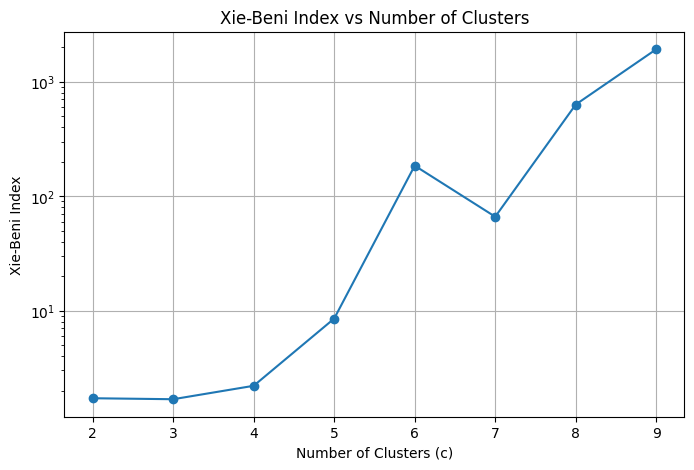

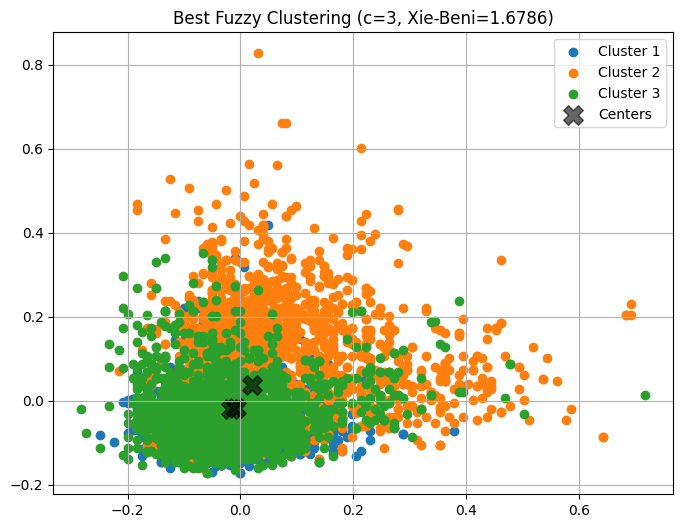

In [5]:
# b) 
costs = []
c_values = list(range(2, 10))
n_runs = 5
seeds=[1, 42, 70, 100, 200]
xie_beni_scores = []
best_results = {}

for c in c_values:
    run_xie_beni_scores = []
    best_xie_beni_score = np.inf
    best_result = None

    for seed in seeds:
        #centers = cluster centers (c, features)
        #fm = final matrix (c, samples)
        #im = initial matrix (c, samples)
        #d = distance from each cluster to each sample (c, samples)
        #jm = history of cost functions for each iteration
        centers, fm, im, d, jm, i, fpc = fuzz.cluster.cmeans(x.T, c, 2.0, 1e-5, 100, init=None, seed=seed)
        
        # Xie-Beni index validation for current run
        xie_score = xie_beni_index(fm, centers, x)
        run_xie_beni_scores.append(xie_score)
        print(f"Seed: {seed} | c={c} | Xie-Beni={xie_score:.4f}") 

        # Best result based on Xie-Beni score
        if xie_score < best_xie_beni_score:
            best_xie_beni_score = xie_score
            best_result = (centers, fm, xie_score)

    #  Store the best result for the current 
    xie_beni_scores.append(best_xie_beni_score)
    best_results[c] = best_result


# Plot Xie-Beni Index vs Number of Clusters (best Xie-Beni for each c)
plt.figure(figsize=(8, 5))
plt.plot(c_values, xie_beni_scores, marker='o', linestyle='-')
plt.title("Xie-Beni Index vs Number of Clusters")
plt.xlabel("Number of Clusters (c)")
plt.ylabel("Xie-Beni Index")
plt.yscale('log')
plt.grid(True)
plt.show()

# Best c based on lowest Xie-Beni score
best_c = c_values[np.argmin(xie_beni_scores)]  
best_centers, best_fm, best_xie_beni = best_results[best_c]

# Convert fuzzy partition matrix to hard labels
labels = np.argmax(best_fm, axis=0)

# Plot the best clustering (for the best c)
plt.figure(figsize=(8, 6))
for j in range(best_c):
    plt.scatter(x[labels == j, 0], x[labels == j, 1], label=f'Cluster {j+1}')
    
plt.scatter(best_centers[:, 0], best_centers[:, 1], c='black', s=200, alpha=0.6, marker='X', label='Centers')
plt.title(f'Best Fuzzy Clustering (c={best_c}, Xie-Beni={best_xie_beni:.4f})')
plt.legend()
plt.grid(True)
plt.show()